# Naive Bayes 

In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('college_student_placement_dataset.csv')
df.head(5)

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [3]:
def preprocess_train(X_train, y_train):
    X_train_proc = X_train.copy()
    y_train_proc = y_train.copy()
    #cgpa which is higher than 10 will be replaced by the mean of cgpa 
    #after converting values higher than 10 into null.the added values are now converted into floating point
    X_train_proc.loc[X_train_proc['CGPA'] > 10, 'CGPA'] = np.nan
    cgpa_mean_val = X_train_proc['CGPA'].mean()
    X_train_proc.fillna({'CGPA': cgpa_mean_val}, inplace=True)
    X_train_proc['CGPA'] = pd.to_numeric(X_train_proc['CGPA'], errors='coerce')
    
    #CollegeID is encoded using target encoding method where placement coloumn is encoded for integer values 
    temp_df = X_train_proc.copy()
    temp_df['Placement_Target'] = y_train_proc
    target_encoding_map = temp_df.groupby('College_ID')['Placement_Target'].mean()
    X_train_proc['College_ID'] = X_train_proc['College_ID'].map(target_encoding_map)
    
    #Internship_experience is also a categorical value
    X_train_proc = pd.get_dummies(X_train_proc, columns=['Internship_Experience'], drop_first=True)
    
    #Oversampling for Placement values as Yes is a minority in the dataset with only 17%
    counts = y_train_proc.value_counts()
    majority_count = counts.max()
    minority_count = counts.min()
    minority_class = counts.idxmin()
    
    n_duplicates_needed = majority_count - minority_count
    
    X_minority = X_train_proc[y_train_proc == minority_class]
    y_minority = y_train_proc[y_train_proc == minority_class]

    X_oversampled = X_minority.sample(n=n_duplicates_needed, replace=True, random_state=42)
    y_oversampled = y_minority.sample(n=n_duplicates_needed, replace=True, random_state=42)

    X_train_proc = pd.concat([X_train_proc, X_oversampled])
    y_train_proc = pd.concat([y_train_proc, y_oversampled])
    
    return X_train_proc, y_train_proc, cgpa_mean_val, target_encoding_map

In [4]:
def preprocess_test(X_test, cgpa_mean_val, target_encoding_map):
    X_test_proc = X_test.copy()
    #cgpa which is higher than 10 will be replaced by the mean of cgpa 
    #after converting values higher than 10 into null.the added values are now converted into floating point
    X_test_proc.loc[X_test_proc['CGPA'] > 10, 'CGPA'] = np.nan
    X_test_proc.fillna({'CGPA':cgpa_mean_val}, inplace=True)
    X_test_proc['CGPA'] = pd.to_numeric(X_test_proc['CGPA'], errors='coerce')
    
    #CollegeID is encoded using target encoding method where placement coloumn is encoded for integer values 
    global_mean = target_encoding_map.mean()
    X_test_proc['College_ID'] = X_test_proc['College_ID'].map(target_encoding_map).fillna(global_mean)
    
    #Internship_experience is also a categorical value
    X_test_proc = pd.get_dummies(X_test_proc, columns=['Internship_Experience'], drop_first=True)
    
    return X_test_proc

In [5]:
x = df.drop('Placement', axis=1)
y = df['Placement'].map({'No':0, 'Yes':1})

In [6]:
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1_scores = []
train_accuracies = []
val_accuracies = []
print(f"Starting Stratified {N_SPLITS}-Fold Cross-Validation with Preprocessing Pipelining")

for fold, (train_index, val_index) in enumerate(skf.split(x, y), 1):
    X_train_raw, X_test_raw = x.iloc[train_index], x.iloc[val_index]
    y_train_raw, y_test = y.iloc[train_index], y.iloc[val_index]
    
    try:
        X_train_proc, y_train_proc, cgpa_mean, enc_map = preprocess_train(X_train_raw, y_train_raw)
        X_test_proc = preprocess_test(X_test_raw.copy(), cgpa_mean, enc_map)
        
        X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)
    
        model = GaussianNB()
        model.fit(X_train_proc, y_train_proc)
        y_pred = model.predict(X_test_proc)
        
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)
    
        train_acc = accuracy_score(y_train_proc, model.predict(X_train_proc))
        val_acc = accuracy_score(y_test, model.predict(X_test_proc))
    
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
    
        diff = train_acc - val_acc
        print(diff)
    except Exception as e :
        print(f"error during{fold}. Skipping this feild{e} ")
        continue
print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f}")
    
results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Training Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies
})

Starting Stratified 5-Fold Cross-Validation with Preprocessing Pipelining
0.035106115107913616
0.03675176082721421
0.036178255657125735
0.04380503521654422
0.024158024876367423

Average Accuracy: 0.8019


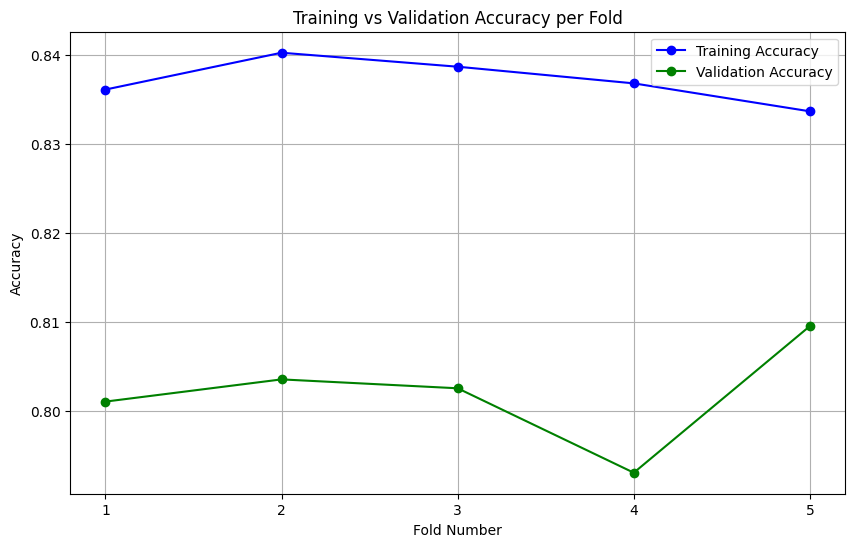


 Summary 
Average Training Accuracy:   0.8371
Average Validation Accuracy: 0.8019
Model is generalizing well (Train ≈ Val)


In [7]:
if len(train_accuracies) < 5:
    print("\nWarning: Not all 3 folds completed. Visualization may be inaccurate.")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df['Fold'], results_df['Training Accuracy'], marker='o', label='Training Accuracy', color='blue')
plt.plot(results_df['Fold'], results_df['Validation Accuracy'], marker='o', label='Validation Accuracy', color='green')

plt.title('Training vs Validation Accuracy per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

# Summary
avg_train = np.mean(train_accuracies)
avg_val = np.mean(val_accuracies)
print("\n Summary ")
print(f"Average Training Accuracy:   {avg_train:.4f}")
print(f"Average Validation Accuracy: {avg_val:.4f}")

if (avg_train - avg_val) > 0.05:
    print("Warning: Potential Overfitting detected (Train >> Val)")
else:
    print("Model is generalizing well (Train ≈ Val)")